# Import

In [20]:
!nvidia-smi

Thu Dec 31 02:17:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   52C    P2   107W / 350W |   1687MiB / 24268MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import pandas as pd
import numpy as np
import cupy as cp
import os
import gc
import time
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
print(torch.__version__)
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline
from janest_model import MLPNet , CustomDataset
from utils import *

1.7.1+cu110


In [3]:
#%%writefile test.py
#print('hello world!')

## Parameter setting

In [11]:
TRAINING = True
USE_FINETUNE = True     
FOLDS = 5
SEED = 66
INPUTPATH = '../../input'
NUM_EPOCH = 1000
BATCH_SIZE = 16384
PATIANCE = 30
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MDL_PATH  = '../models'
MDL_NAME = 'mlp'
NUM_LYR = 5
VER = 'base'

## Import Data 

In [12]:
%%time
train = pd.read_parquet(f'{INPUTPATH}/train.parquet')
test_df = pd.read_csv(f'{INPUTPATH}/example_test.csv')
pred_df  = pd.read_csv(f'{INPUTPATH}/example_sample_submission.csv')

CPU times: user 8.6 s, sys: 4.23 s, total: 12.8 s
Wall time: 1.26 s


In [6]:
test_df.head()

,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,date,ts_id
0,0.000000,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,...,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0
1,16.673515,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,...,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,0,1
2,0.000000,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,...,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,0,2
3,0.000000,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,...,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,0,3
4,0.138531,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,...,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,0,4


In [6]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,1,3.151305,5.467693,...,2.433699,4.282284,1.621115,4.331030,2.553220,3.799011,2.642943,3.998054,527894,0
1,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,-1,-0.365888,0.824004,...,-0.702873,4.038753,-0.789767,4.133183,-1.207878,3.402796,-0.928290,3.511141,527896,0
2,86,0.172997,0.000168,0.000333,-0.002375,-0.003064,0.001527,1,1.514607,0.596214,...,2.304354,1.530169,3.596848,4.613493,4.516110,3.341374,2.635798,1.535235,527897,0
3,86,1.507813,0.001534,0.000481,-0.000082,-0.002271,-0.001663,-1,-1.008999,0.242132,...,-1.700655,-0.376747,-0.876730,1.645537,-1.318172,1.369452,-1.352577,0.733124,527900,0
4,86,5.554003,0.003948,0.005943,0.015943,0.025001,0.017121,-1,-0.391784,0.152261,...,-1.690686,1.656818,-1.213169,2.949877,-2.033542,2.248799,-1.838696,1.905638,527901,1


# Features

In [14]:
%%time
train = train.query('date > 85').reset_index(drop = True) 
print(train.shape)
train.fillna(train.mean(),inplace=True)
train = train.query('weight > 0').reset_index(drop = True)
train['action'] =  \
(  (train['resp_1'] > 0.00001 ) & \
   (train['resp_2'] > 0.00001 ) & \
   (train['resp_3'] > 0.00001 ) & \
   (train['resp_4'] > 0.00001 ) & \
   (train['resp'] > 0.00001 )   ).astype('int')

features = [c for c in train.columns if 'feature' in c]

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

X = train[features].values
y = np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T
#X = cp.array(train[features].values)
#y = cp.array(np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T) #Multitarget
#f_mean = np.mean(train[features[1:]].values,axis=0)

f_mean = np.load( f'{INPUTPATH}/f_mean.npy')

(1571415, 139)
CPU times: user 1.74 s, sys: 735 ms, total: 2.47 s
Wall time: 2.47 s


In [8]:
#%%time
#np.save( f'{INPUTPATH}/f_mean.npy',f_mean)

In [9]:
print(X.shape[-1])
print(y.shape[-1])

130
5


# Trainning

## MLP

In [8]:
#model = autoencoder(input_size = X.shape[-1], output_size = y.shape[-1], noise=0.1).to(DEVICE)
model = MLPNet(input_size = X.shape[-1], output_size = y.shape[-1]).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, weight_decay=1e-5)

In [10]:
dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
sts = time.time()
best_score = 100
counter = 0
epoch_list = []
score_list = []
for epoch in tqdm(range(NUM_EPOCH)):
    score = 0
    for data in dataloader:
        x = data['x'].to(DEVICE)
        y = data['y'].to(DEVICE)
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, y)
        score +=  loss.data.to('cpu').detach().numpy().copy()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    
    
    if score <= best_score:
        counter  = 0
        best_score = score.copy()
        if not os.path.exists(f'{MDL_PATH}/{MDL_NAME}_{VER}'):
            os.mkdir(f'{MDL_PATH}/{MDL_NAME}_{VER}')
        save_path = f'{MDL_PATH}/{MDL_NAME}_{VER}/{MDL_NAME}_'+str(epoch+ 1)+'.pth'
        best_model = model.state_dict()
        
    else:
        counter += 1
        if counter == PATIANCE:
            print('Loss did not improved for {} epochs'.format(PATIANCE))
            torch.save(best_model, save_path)
            print('The best mse loss is {:.4f}'.format(best_score))
            break
    epoch_list.append(epoch+1)
    score_list.append(score)
    
    print('Epoch [{}/{}],        MSE loss: {:.4f},       Early stopping counter: {}'
          .format(epoch + 1, NUM_EPOCH, score, counter))
if counter != PATIANCE:
    print('The best mse loss is {:.4f}'.format(best_score))
    torch.save(best_model, save_path)
learn_hist = pd.DataFrame()
learn_hist['epoch'] = epoch_list
learn_hist['mse_loss'] = score_list
ed = time.time()
print('Training process takes {:.2f} min.'.format((ed-sts)/60))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000],        MSE loss: 23.8891,       Early stopping counter: 0
Epoch [2/1000],        MSE loss: 23.8263,       Early stopping counter: 0
Epoch [3/1000],        MSE loss: 23.8042,       Early stopping counter: 0
Epoch [4/1000],        MSE loss: 23.7891,       Early stopping counter: 0
Epoch [5/1000],        MSE loss: 23.7769,       Early stopping counter: 0
Epoch [6/1000],        MSE loss: 23.7696,       Early stopping counter: 0
Epoch [7/1000],        MSE loss: 23.7593,       Early stopping counter: 0
Epoch [8/1000],        MSE loss: 23.7491,       Early stopping counter: 0
Epoch [9/1000],        MSE loss: 23.7417,       Early stopping counter: 0
Epoch [10/1000],        MSE loss: 23.7336,       Early stopping counter: 0
Epoch [11/1000],        MSE loss: 23.7262,       Early stopping counter: 0
Epoch [12/1000],        MSE loss: 23.7193,       Early stopping counter: 0
Epoch [13/1000],        MSE loss: 23.7121,       Early stopping counter: 0
Epoch [14/1000],        MSE loss: 

Epoch [111/1000],        MSE loss: 22.5962,       Early stopping counter: 0
Epoch [112/1000],        MSE loss: 22.5854,       Early stopping counter: 0
Epoch [113/1000],        MSE loss: 22.5789,       Early stopping counter: 0
Epoch [114/1000],        MSE loss: 22.5740,       Early stopping counter: 0
Epoch [115/1000],        MSE loss: 22.5615,       Early stopping counter: 0
Epoch [116/1000],        MSE loss: 22.5604,       Early stopping counter: 0
Epoch [117/1000],        MSE loss: 22.5551,       Early stopping counter: 0
Epoch [118/1000],        MSE loss: 22.5449,       Early stopping counter: 0
Epoch [119/1000],        MSE loss: 22.5421,       Early stopping counter: 0
Epoch [120/1000],        MSE loss: 22.5400,       Early stopping counter: 0
Epoch [121/1000],        MSE loss: 22.5327,       Early stopping counter: 0
Epoch [122/1000],        MSE loss: 22.5222,       Early stopping counter: 0
Epoch [123/1000],        MSE loss: 22.5186,       Early stopping counter: 0
Epoch [124/1

Epoch [219/1000],        MSE loss: 22.1414,       Early stopping counter: 0
Epoch [220/1000],        MSE loss: 22.1380,       Early stopping counter: 0
Epoch [221/1000],        MSE loss: 22.1363,       Early stopping counter: 0
Epoch [222/1000],        MSE loss: 22.1397,       Early stopping counter: 1
Epoch [223/1000],        MSE loss: 22.1322,       Early stopping counter: 0
Epoch [224/1000],        MSE loss: 22.1226,       Early stopping counter: 0
Epoch [225/1000],        MSE loss: 22.1260,       Early stopping counter: 1
Epoch [226/1000],        MSE loss: 22.1216,       Early stopping counter: 0
Epoch [227/1000],        MSE loss: 22.1164,       Early stopping counter: 0
Epoch [228/1000],        MSE loss: 22.1109,       Early stopping counter: 0
Epoch [229/1000],        MSE loss: 22.1123,       Early stopping counter: 1
Epoch [230/1000],        MSE loss: 22.1193,       Early stopping counter: 2
Epoch [231/1000],        MSE loss: 22.1252,       Early stopping counter: 3
Epoch [232/1

Epoch [327/1000],        MSE loss: 21.9336,       Early stopping counter: 0
Epoch [328/1000],        MSE loss: 21.9373,       Early stopping counter: 1
Epoch [329/1000],        MSE loss: 21.9322,       Early stopping counter: 0
Epoch [330/1000],        MSE loss: 21.9311,       Early stopping counter: 0
Epoch [331/1000],        MSE loss: 21.9356,       Early stopping counter: 1
Epoch [332/1000],        MSE loss: 21.9237,       Early stopping counter: 0
Epoch [333/1000],        MSE loss: 21.9116,       Early stopping counter: 0
Epoch [334/1000],        MSE loss: 21.9254,       Early stopping counter: 1
Epoch [335/1000],        MSE loss: 21.9268,       Early stopping counter: 2
Epoch [336/1000],        MSE loss: 21.9215,       Early stopping counter: 3
Epoch [337/1000],        MSE loss: 21.9195,       Early stopping counter: 4
Epoch [338/1000],        MSE loss: 21.9173,       Early stopping counter: 5
Epoch [339/1000],        MSE loss: 21.9074,       Early stopping counter: 0
Epoch [340/1

Epoch [435/1000],        MSE loss: 21.8125,       Early stopping counter: 0
Epoch [436/1000],        MSE loss: 21.8095,       Early stopping counter: 0
Epoch [437/1000],        MSE loss: 21.8126,       Early stopping counter: 1
Epoch [438/1000],        MSE loss: 21.8173,       Early stopping counter: 2
Epoch [439/1000],        MSE loss: 21.8128,       Early stopping counter: 3
Epoch [440/1000],        MSE loss: 21.8187,       Early stopping counter: 4
Epoch [441/1000],        MSE loss: 21.8168,       Early stopping counter: 5
Epoch [442/1000],        MSE loss: 21.8104,       Early stopping counter: 6
Epoch [443/1000],        MSE loss: 21.8122,       Early stopping counter: 7
Epoch [444/1000],        MSE loss: 21.8156,       Early stopping counter: 8
Epoch [445/1000],        MSE loss: 21.8038,       Early stopping counter: 0
Epoch [446/1000],        MSE loss: 21.8068,       Early stopping counter: 1
Epoch [447/1000],        MSE loss: 21.8072,       Early stopping counter: 2
Epoch [448/1

Epoch [543/1000],        MSE loss: 21.7335,       Early stopping counter: 4
Epoch [544/1000],        MSE loss: 21.7303,       Early stopping counter: 5
Epoch [545/1000],        MSE loss: 21.7326,       Early stopping counter: 6
Epoch [546/1000],        MSE loss: 21.7467,       Early stopping counter: 7
Epoch [547/1000],        MSE loss: 21.7240,       Early stopping counter: 0
Epoch [548/1000],        MSE loss: 21.7292,       Early stopping counter: 1
Epoch [549/1000],        MSE loss: 21.7336,       Early stopping counter: 2
Epoch [550/1000],        MSE loss: 21.7191,       Early stopping counter: 0
Epoch [551/1000],        MSE loss: 21.7275,       Early stopping counter: 1
Epoch [552/1000],        MSE loss: 21.7268,       Early stopping counter: 2
Epoch [553/1000],        MSE loss: 21.7298,       Early stopping counter: 3
Epoch [554/1000],        MSE loss: 21.7380,       Early stopping counter: 4
Epoch [555/1000],        MSE loss: 21.7263,       Early stopping counter: 5
Epoch [556/1

Epoch [651/1000],        MSE loss: 21.6651,       Early stopping counter: 0
Epoch [652/1000],        MSE loss: 21.6631,       Early stopping counter: 0
Epoch [653/1000],        MSE loss: 21.6676,       Early stopping counter: 1
Epoch [654/1000],        MSE loss: 21.6709,       Early stopping counter: 2
Epoch [655/1000],        MSE loss: 21.6675,       Early stopping counter: 3
Epoch [656/1000],        MSE loss: 21.6640,       Early stopping counter: 4
Epoch [657/1000],        MSE loss: 21.6710,       Early stopping counter: 5
Epoch [658/1000],        MSE loss: 21.6636,       Early stopping counter: 6
Epoch [659/1000],        MSE loss: 21.6578,       Early stopping counter: 0
Epoch [660/1000],        MSE loss: 21.6727,       Early stopping counter: 1
Epoch [661/1000],        MSE loss: 21.6714,       Early stopping counter: 2
Epoch [662/1000],        MSE loss: 21.6696,       Early stopping counter: 3
Epoch [663/1000],        MSE loss: 21.6720,       Early stopping counter: 4
Epoch [664/1

Epoch [759/1000],        MSE loss: 21.6248,       Early stopping counter: 3
Epoch [760/1000],        MSE loss: 21.6141,       Early stopping counter: 0
Epoch [761/1000],        MSE loss: 21.6194,       Early stopping counter: 1
Epoch [762/1000],        MSE loss: 21.6201,       Early stopping counter: 2
Epoch [763/1000],        MSE loss: 21.6255,       Early stopping counter: 3
Epoch [764/1000],        MSE loss: 21.6267,       Early stopping counter: 4
Epoch [765/1000],        MSE loss: 21.6258,       Early stopping counter: 5
Epoch [766/1000],        MSE loss: 21.6284,       Early stopping counter: 6
Epoch [767/1000],        MSE loss: 21.6195,       Early stopping counter: 7
Epoch [768/1000],        MSE loss: 21.6220,       Early stopping counter: 8
Epoch [769/1000],        MSE loss: 21.6213,       Early stopping counter: 9
Epoch [770/1000],        MSE loss: 21.6240,       Early stopping counter: 10
Epoch [771/1000],        MSE loss: 21.6220,       Early stopping counter: 11
Epoch [772

Epoch [867/1000],        MSE loss: 21.5937,       Early stopping counter: 13
Epoch [868/1000],        MSE loss: 21.5828,       Early stopping counter: 14
Epoch [869/1000],        MSE loss: 21.5916,       Early stopping counter: 15
Epoch [870/1000],        MSE loss: 21.5829,       Early stopping counter: 16
Epoch [871/1000],        MSE loss: 21.5924,       Early stopping counter: 17
Epoch [872/1000],        MSE loss: 21.5744,       Early stopping counter: 0
Epoch [873/1000],        MSE loss: 21.5816,       Early stopping counter: 1
Epoch [874/1000],        MSE loss: 21.5777,       Early stopping counter: 2
Epoch [875/1000],        MSE loss: 21.5848,       Early stopping counter: 3
Epoch [876/1000],        MSE loss: 21.5835,       Early stopping counter: 4
Epoch [877/1000],        MSE loss: 21.5782,       Early stopping counter: 5
Epoch [878/1000],        MSE loss: 21.5828,       Early stopping counter: 6
Epoch [879/1000],        MSE loss: 21.5792,       Early stopping counter: 7
Epoch [

Epoch [975/1000],        MSE loss: 21.5589,       Early stopping counter: 3
Epoch [976/1000],        MSE loss: 21.5494,       Early stopping counter: 4
Epoch [977/1000],        MSE loss: 21.5524,       Early stopping counter: 5
Epoch [978/1000],        MSE loss: 21.5561,       Early stopping counter: 6
Epoch [979/1000],        MSE loss: 21.5588,       Early stopping counter: 7
Epoch [980/1000],        MSE loss: 21.5560,       Early stopping counter: 8
Epoch [981/1000],        MSE loss: 21.5628,       Early stopping counter: 9
Epoch [982/1000],        MSE loss: 21.5548,       Early stopping counter: 10
Epoch [983/1000],        MSE loss: 21.5470,       Early stopping counter: 11
Epoch [984/1000],        MSE loss: 21.5392,       Early stopping counter: 0
Epoch [985/1000],        MSE loss: 21.5673,       Early stopping counter: 1
Epoch [986/1000],        MSE loss: 21.5565,       Early stopping counter: 2
Epoch [987/1000],        MSE loss: 21.5581,       Early stopping counter: 3
Epoch [988

In [15]:
learn_hist.to_csv(f'{MDL_PATH}/{MDL_NAME}_{VER}/{MDL_NAME}_.csv', index=False)

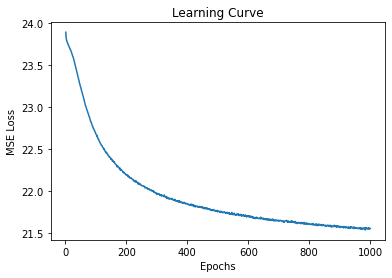

In [16]:
plt.plot(learn_hist.epoch, learn_hist.mse_loss)
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('Learning Curve')
plt.show()

In [17]:
@njit(fastmath = True)
def utility_score_numba(date, weight, resp, action):
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

#https://www.kaggle.com/gogo827jz/jane-street-super-fast-utility-score-function

In [18]:
epoch = 983
save_path = f'{MDL_PATH}/{MDL_NAME}_{VER}/{MDL_NAME}_'+str(epoch+ 1)+'.pth'
model = MLPNet(input_size = X.shape[-1], output_size = y.shape[-1]).to(DEVICE)
load_weights = torch.load(save_path)
model.load_state_dict(load_weights)
model.eval()

MLPNet(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (bat): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): Sigmoid()
  (encoder): Sequential(
    (0): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=130, out_features=512, bias=True)
    (2): ReLU(inplace=True)
  )
)

In [19]:
torch.cuda.empty_cache()

In [21]:
th = 0
loop = int(np.round(len(X)/BATCH_SIZE))
pred_all = np.array([])
for n in tqdm(range(loop)):
    x_tt = X[BATCH_SIZE*n:BATCH_SIZE*(n+1),:]
    if np.isnan(x_tt[:, 1:].sum()):
        x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
    pred = 0.0
    X_test = torch.FloatTensor(x_tt).to(DEVICE)
    pred= model(X_test).cpu().detach().numpy()
    if len(pred_all) == 0:
        pred_all = pred.copy()
    else:
        pred_all = np.vstack([pred_all, pred]).copy()

  0%|          | 0/96 [00:00<?, ?it/s]

In [100]:
X_test.shape

torch.Size([14935, 130])

In [24]:
date = train['date'].values
weight = train['weight'].values
resp = train['resp'].values
train['action'] = (train['resp'] > 0).astype('int')
action_ans = train['action'].values

In [25]:
th=0.5
action = np.where(pred_all[:,0] >= th, 1, 0).astype(int).copy()
utility_score_numba(date, weight, resp, action)

48295.42870965015

In [52]:
utility_score_numba(date, weight, resp, action_ans)

173797.76047460194

In [26]:
gc.collect()

10492

## Predict Test 

In [27]:
print(f'{MDL_PATH}/{MDL_NAME}_{VER}')

../models/mlp_base


In [ ]:
#!kaggle datasets init -p ../models/autoencoder_test

In [37]:
%%writefile ../models/mlp_base/dataset-metadata.json
{
    "title": "Jane-Street",
    "id": "shinsei66/Jane-Street",
    "subtitle": "",
    "description": "",
    "isPrivate": true,
    "licenses": [
        {
            "name": "unknown" 
        }
    ],
    "keywords": [],
    "collaborators": [],
    "data": [
        {
            "description": null,
            "name": "autoencoder_99.pth",
            "totalBytes": 848,
            "columns": []
        },
        {
            "description": null,
            "name": "autoencoder_254.pth",
            "totalBytes": 856,
            "columns": []
        },
        {
            "description": null,
            "name": "mlp_base_984.pth",
            "totalBytes": 1316,
            "columns": []
        }
    ]
}

Overwriting ../models/mlp_base/dataset-metadata.json


In [ ]:
#!kaggle datasets create -p  ../models/autoencoder_early_stopping

In [31]:
!du ../models/mlp_base/mlp_984.pth

1316	../models/mlp_base/mlp_984.pth


In [38]:
!kaggle datasets version -p  ../models/mlp_base -m "mlp base 984 epoch"

Starting upload for file mlp_base.csv
100%|███████████████████████████████████████| 22.0k/22.0k [08:48<00:00, 42.6B/s]
Upload successful: mlp_base.csv (22KB)
Starting upload for file mlp_984.pth
100%|██████████████████████████████████████| 1.28M/1.28M [08:47<00:00, 2.55kB/s]
Upload successful: mlp_984.pth (1MB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Dataset version is being created. Please check progress at https://www.kaggle.com/shinsei66/jane-street
